In [1]:
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

from torch_geometric.data import Data

G = nx.read_gexf("similarity_graph.gexf")

nodes = list(G.nodes())
edges = list(G.edges(data=True))

node_id_to_idx = {node: idx for idx, node in enumerate(nodes)}

edge_index = []
edge_weights = []
for src, dst, data in edges:
    edge_index.append([node_id_to_idx[src], node_id_to_idx[dst]])
    edge_weights.append(data.get("weight", 1.0))

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weights = torch.tensor(edge_weights, dtype=torch.float)

data = Data(
    edge_index=edge_index,
    edge_attr=edge_weights,
    num_nodes=len(nodes)
)
data = data.cpu()

In [2]:
class SimilarityGAT(nn.Module):
    def __init__(self, num_nodes, embedding_dim=128, hidden_dim=128, heads=4, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(num_nodes, embedding_dim)
        self.norm1 = nn.LayerNorm(embedding_dim)
        
        self.conv1 = GATConv(
            embedding_dim, 
            hidden_dim, 
            heads=heads,
            edge_dim=1,
            add_self_loops=True
        )
        
        self.norm2 = nn.LayerNorm(hidden_dim * heads)
        self.conv2 = GATConv(
            hidden_dim * heads,
            hidden_dim,
            heads=1,
            edge_dim=1,
            add_self_loops=True
        )
        
        self.norm3 = nn.LayerNorm(hidden_dim)
        self.conv3 = GATConv(
            hidden_dim,
            hidden_dim,
            heads=4,
            edge_dim=1,
            concat=False,
            add_self_loops=True
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.dropout = dropout

    def forward(self, data, return_attention=True):
        edge_attr = data.edge_attr.to(torch.float32).unsqueeze(-1)
        
        x = self.norm1(self.embedding(torch.arange(data.num_nodes, device=data.edge_index.device)))
        
        # Layer 1
        x, (attn_idx1, attn_weights1) = self.conv1(x, data.edge_index, edge_attr=edge_attr, return_attention_weights=True)
        x = F.leaky_relu(self.norm2(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Layer 2
        x, (attn_idx2, attn_weights2) = self.conv2(x, data.edge_index, edge_attr=edge_attr, return_attention_weights=True)
        x = F.leaky_relu(self.norm3(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Layer 3
        x, (attn_idx3, attn_weights3) = self.conv3(x, data.edge_index, edge_attr=edge_attr, return_attention_weights=True)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Decoder
        src, dst = data.edge_index
        edge_features = torch.cat([x[src], x[dst]], dim=1)
        pred_scores = self.decoder(edge_features).squeeze()
        
        if return_attention:
            return pred_scores, (attn_weights1, attn_weights2, attn_weights3)
        return pred_scores

In [3]:
from torch_geometric.loader import NeighborLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimilarityGAT(
    num_nodes=data.num_nodes,
    embedding_dim=64,
    hidden_dim=64,
    heads=4,
    dropout=0.5
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scaler = torch.amp.GradScaler()

data = data.to(device)
data.edge_attr = data.edge_attr.to(torch.float16)

loader = NeighborLoader(
    data,
    num_neighbors=[15, 10, 5],
    batch_size=512,
    shuffle=True
)

def train():
    model.train()
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            pred_scores, attn_weights = model(batch)
            loss = F.mse_loss(pred_scores, batch.edge_attr)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
    return total_loss / len(loader), attn_weights

In [4]:
import torch_geometric
import torch_sparse
import torch_scatter

import time

num_epochs = 100

loss_history = []
final_attn_weights = None

start_time = time.time()
for epoch in range(num_epochs):
    
    epoch_start = time.time()
    
    loss, attn = train()
    
    epoch_duration = time.time() - epoch_start
    elapsed = time.time() - start_time
    avg_epoch_time = elapsed / (epoch + 1)
    remaining_epochs = num_epochs - (epoch + 1)
    remaining_time = remaining_epochs * avg_epoch_time
    
    loss_history.append(loss)
    print(f"\rEpoch {epoch}, Loss: {loss:.4f}, Estimated Remaining Time: {remaining_time:.2f}s", end="")
    final_attn_weights = attn

Epoch 99, Loss: 0.0263, Estimated Remaining Time: 0.00ssss

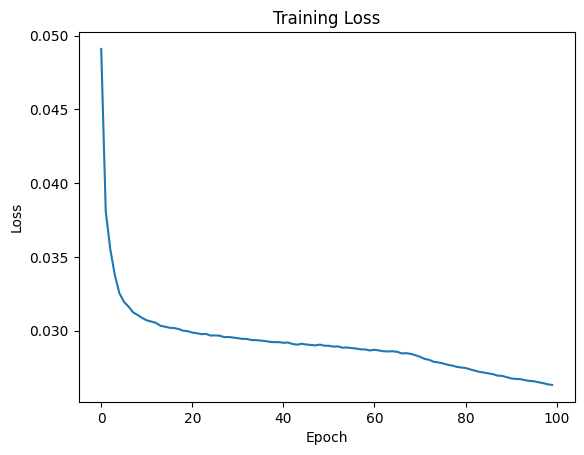

In [5]:
from matplotlib import pyplot as plt

torch.save(loss_history, 'loss_history.pt')

plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('training_loss.png')
plt.show()

In [6]:
node_names = nx.get_node_attributes(G, "name")
nodes = list(G.nodes())
node_id_to_idx = {node_names[node]: idx for idx, node in enumerate(G.nodes())}
idx_to_node = {idx: node_names[node] for idx, node in enumerate(G.nodes())}
print(list(node_id_to_idx.items())[:10])

def create_attention_graph(edge_index, attn_weights):
    src_indices = edge_index[0].detach().cpu().numpy()
    tgt_indices = edge_index[1].detach().cpu().numpy()
    edge_weights = attn_weights.detach().cpu().numpy()
    
    G_attn = nx.DiGraph()
    for node in nodes:
        name = node_names.get(node, node)
        G_attn.add_node(node, name=name)
        
    idx_to_node = {idx: node for node, idx in node_id_to_idx.items()}

    for src_idx, tgt_idx, weight in zip(src_indices, tgt_indices, edge_weights):
        src_node = idx_to_node[src_idx]
        tgt_node = idx_to_node[tgt_idx]
        G_attn.add_edge(src_node, tgt_node, weight=weight)
    
    return G_attn

edge_index = data.edge_index

attn1_agg = final_attn_weights[0].mean(dim=1)

attn2_agg = final_attn_weights[1].squeeze(-1)

attn3_agg = final_attn_weights[2].mean(dim=1)

alpha, beta, gamma = 0.2, 0.3, 0.5
composite_scores = (
    alpha * attn1_agg + 
    beta * attn2_agg + 
    gamma * attn3_agg
)


G_attention = create_attention_graph(data.edge_index, composite_scores)
nx.write_gexf(G_attention, "attention_composite.gexf")

[('The Beatles', 0), ('Metallica', 1), ('KISS', 2), ('Nirvana', 3), ('Led Zeppelin', 4), ('Queen', 5), ('The Smashing Pumpkins', 6), ('Iron Maiden', 7), ('Motörhead', 8), ('Deep Purple', 9)]


In [7]:
def predict_similarity(artist_a, artist_b, model, data, node_id_to_idx):
    idx_a = node_id_to_idx[artist_a]
    idx_b = node_id_to_idx[artist_b]
    
    edge_index = torch.tensor([[idx_a], [idx_b]], device=data.edge_index.device)
    edge_attr = torch.ones(1, dtype=torch.float32, device=data.edge_index.device) # dummy
    
    inference_data = Data(
        edge_index=edge_index,
        edge_attr=edge_attr,
        num_nodes=data.num_nodes
    ).to(data.edge_index.device)
    
    model.eval()
    with torch.no_grad():
        pred_score = model(inference_data, return_attention=False)
    
    return pred_score.item()

artist1 = "Tool"
artist2 = "Napalm Death"
similarity = predict_similarity(artist1, artist2, model, data, node_id_to_idx)
print(f"Predicted similarity: {similarity:.4f}")

Predicted similarity: 0.1976
